<a href="https://colab.research.google.com/github/shelke16/DL/blob/main/Movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [38]:
from google.colab import files
uploaded = files.upload()

Saving imdb_top_1000.csv to imdb_top_1000 (2).csv


In [39]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [40]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

In [41]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [42]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

In [46]:
import tensorflow as tf
import tensorflow_hub as hub

embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

# Wrap the hub_layer in a tf.keras.layers.Layer to ensure compatibility
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_layer):
        super(HubLayerWrapper, self).__init__()
        self.hub_layer = hub_layer



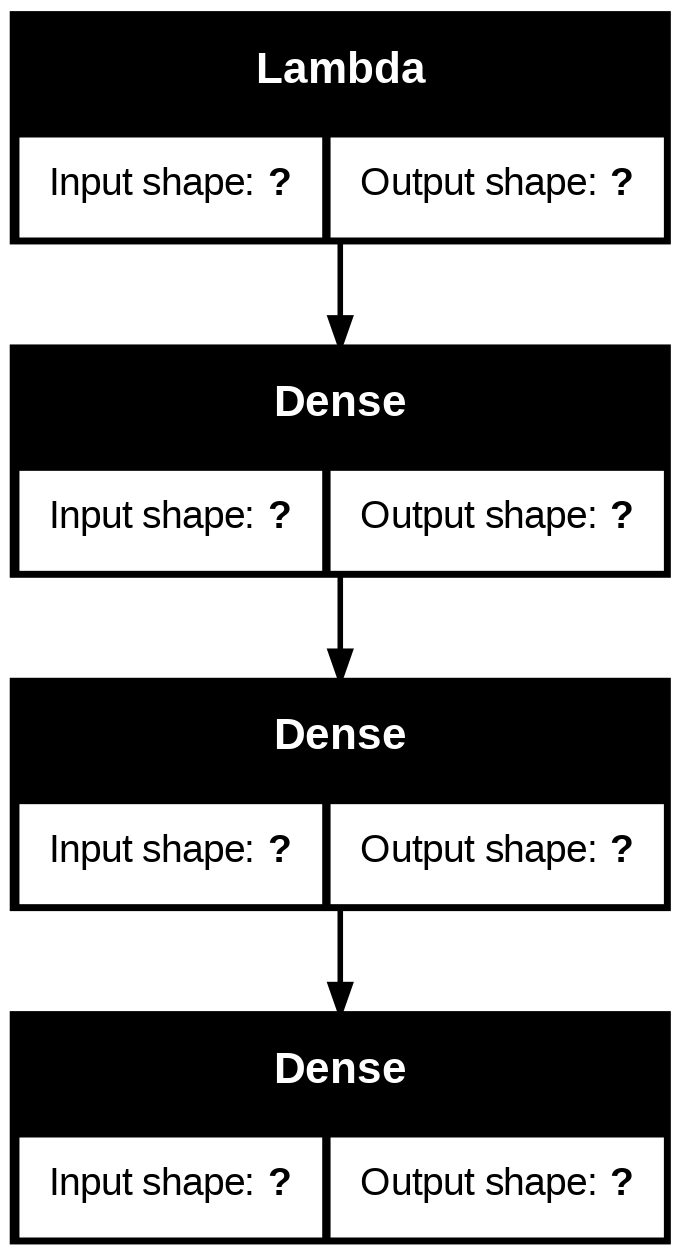

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [48]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-2 (Dense)          │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output-layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,021 (54.77 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,348 (36.52 KB)

In [49]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.7492 - loss: 0.5312 - val_accuracy: 0.7554 - val_loss: 0.5235
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7693 - loss: 0.5036 - val_accuracy: 0.7682 - val_loss: 0.5527
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7819 - loss: 0.4857 - val_accuracy: 0.7864 - val_loss: 0.5140
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7992 - loss: 0.4715 - val_accuracy: 0.7852 - val_loss: 0.5096
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7956 - loss: 0.4685 - val_accuracy: 0.7838 - val_loss: 0.4954


In [51]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 3s - 63ms/step - accuracy: 0.7837 - loss: 0.4824
loss: 0.482
compile_metrics: 0.784


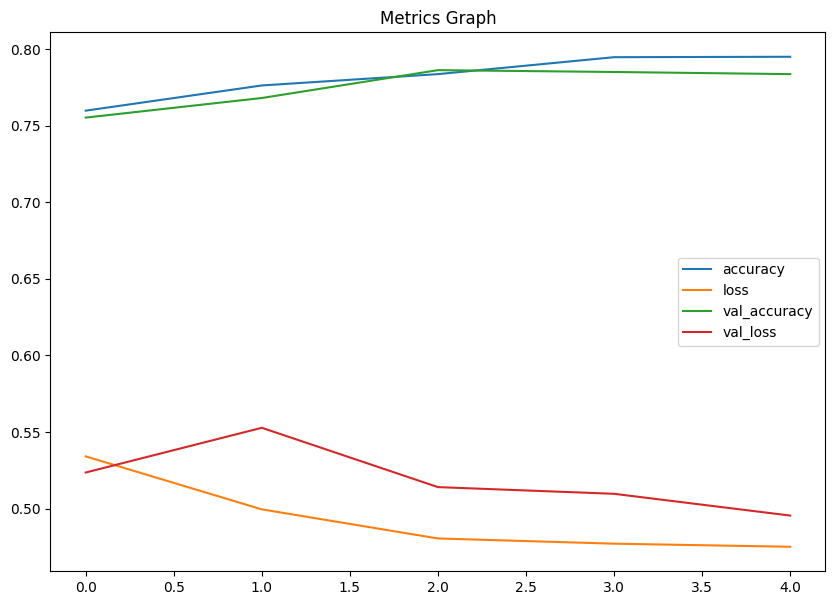

In [52]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.title("Metrics Graph")
plt.show()

In [55]:
texts = []
true_labels = []
for text, label in test_data:
    texts.append(text.numpy().decode('utf-8'))
    true_labels.append(label.numpy())
texts = np.array(texts)
true_labels = np.array(true_labels)

In [59]:
predicted_probs = model.predict(tf.convert_to_tensor(texts))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


In [61]:
predicted_labels = (predicted_probs > 0.5).astype(int)

In [62]:
report = metrics.classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.74      0.87      0.80     12500
    Positive       0.84      0.70      0.76     12500

    accuracy                           0.78     25000
   macro avg       0.79      0.78      0.78     25000
weighted avg       0.79      0.78      0.78     25000



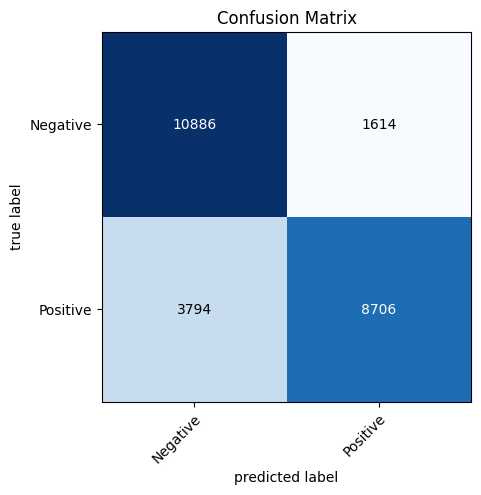

In [63]:
cm = metrics.confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.show()